<a href="https://colab.research.google.com/github/titusjscott/multi-layer-perceptron/blob/main/activity_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import Sequential
from keras.utils import to_categorical
from google.colab import files

In [2]:
uploaded = files.upload()

train = pd.read_csv('activity_recognition_train.csv')

Saving activity_recognition_train.csv to activity_recognition_train.csv


In [3]:
train.shape

(7352, 563)

In [4]:
uploaded = files.upload()

test = pd.read_csv('activity_recognition_test.csv')

Saving activity_recognition_test.csv to activity_recognition_test.csv


In [5]:
test.shape

(2947, 563)

In [6]:
# combine train and test dataframes into one to get big picture of data

df = pd.concat([train, test])

df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [7]:
df.shape

(10299, 563)

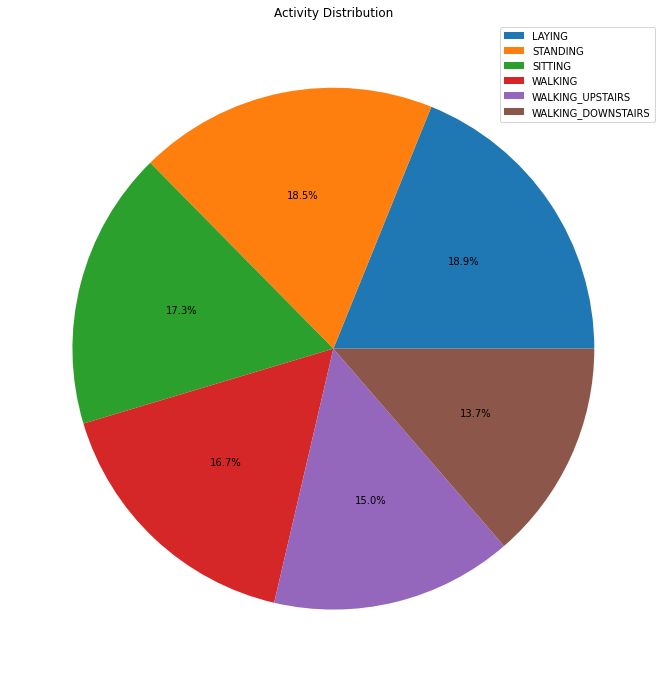

In [9]:
# Create a figure to identify distribution of Activities from entire Data Set
plt.figure(figsize=(12, 12))

# Count the frequency of each activity
activity_counts = df['Activity'].value_counts()

# Create a pie chart with labels and percentages
plt.pie(activity_counts, autopct='%1.1f%%')

# Add a title
plt.title('Activity Distribution')

# Add the counts as a legend
plt.legend(labels=activity_counts.index, loc="best")

# Display the chart
plt.show()


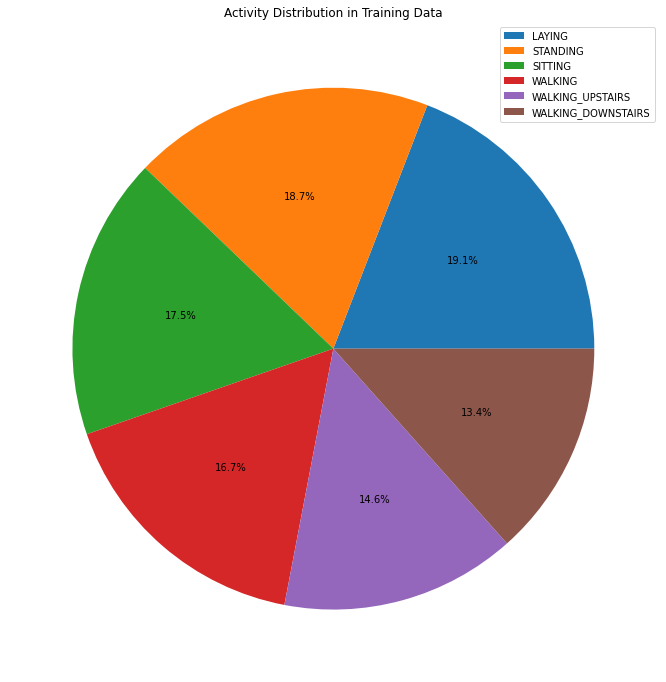

In [12]:
# Pie Chart for Activity distribution from Training dataframe
plt.figure(figsize=(12, 12))

# Count the frequency of each activity
activity_counts = train['Activity'].value_counts()

# Create a pie chart with labels and percentages
plt.pie(activity_counts, autopct='%1.1f%%')

# Add a title
plt.title('Activity Distribution in Training Data')

# Add the counts as a legend
plt.legend(labels=activity_counts.index, loc="best")

# Display the chart
plt.show()

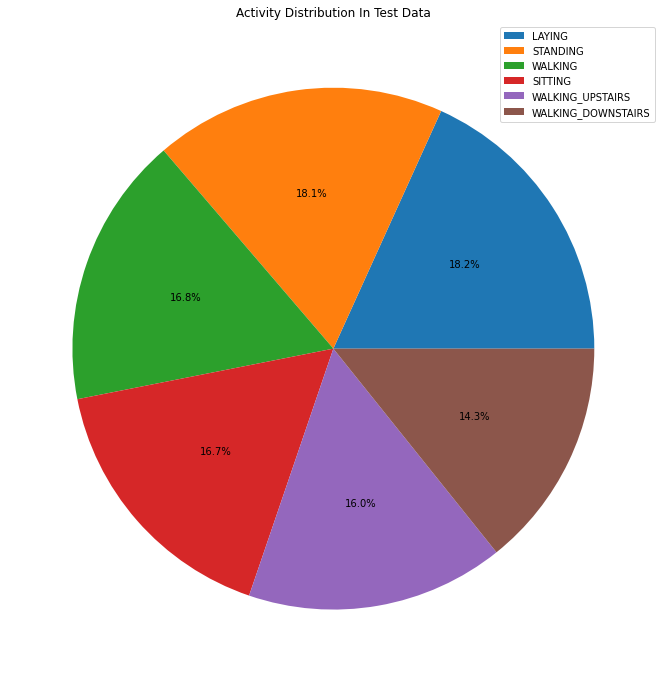

In [13]:
# Pie Chart for Activity distribution from Test dataframe
plt.figure(figsize=(12, 12))

# Count the frequency of each activity
activity_counts = test['Activity'].value_counts()

# Create a pie chart with labels and percentages
plt.pie(activity_counts, autopct='%1.1f%%')

# Add a title
plt.title('Activity Distribution In Test Data')

# Add the counts as a legend
plt.legend(labels=activity_counts.index, loc="upper right")

# Display the chart
plt.show()

In [14]:
X_train = train.drop(['subject', 'Activity'], axis = 1)
y_train = train.Activity

X_test = test.drop(['subject', 'Activity'], axis = 1)
y_test = test.Activity

print('Training Data Shape:', X_train.shape)
print('Test Data Shape:', X_test.shape)

Training Data Shape: (7352, 561)
Test Data Shape: (2947, 561)


In [15]:
# Change the Activity column to numerical data

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [16]:
# Check to find out if there are other columns that need to be converted to numeric

non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

if len(non_numeric_cols) > 0:
    print(f"The following columns are not numeric: {non_numeric_cols}")
else:
    print("All columns are numeric")

The following columns are not numeric: ['Activity']


In [17]:
scaled = MinMaxScaler()
X_train = scaled.fit_transform(X_train)
X_test = scaled.fit_transform(X_test)

Build an Autoencoder

In [18]:
# Define the input shape of the autoencoder
input_shape = (561,)

# Define the number of classes
num_classes = 6

# Define the size of the encoded representation
encoding_dim = 64

# Define the input layer
input_layer = Input(shape=input_shape)

# Convert the labels to one-hot encoded format
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)
y_train_categorical = to_categorical(y_train)

# Define the encoder layers
encoder_layer_1 = Dense(256, activation='relu')(input_layer)
encoder_layer_2 = Dense(128, activation='relu')(encoder_layer_1)
encoder_layer_3 = Dense(encoding_dim, activation='relu')(encoder_layer_2)

# Define the decoder layers
decoder_layer_1 = Dense(128, activation='relu')(encoder_layer_3)
decoder_layer_2 = Dense(256, activation='relu')(decoder_layer_1)
decoder_layer_3 = Dense(input_shape[0], activation='sigmoid')(decoder_layer_2)

# Define the autoencoder model
autoencoder = Model(input_layer, decoder_layer_3)

# Define the encoder model
encoder_model = Model(input_layer, encoder_layer_3)

# Define the classifier model
classifier_model = Sequential()
classifier_model.add(Dense(64, activation='relu', input_dim=64))
classifier_model.add(Dense(32, activation='relu'))
classifier_model.add(Dense(6, activation='softmax'))


# Compile the models
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Fit the autoencoder model
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))

# Extract the encoded representation of the data
encoded_data = encoder_model.predict(X_train)

encoded_train = encoder_model.predict(X_train)
encoded_test = encoder_model.predict(X_test)

# Fit the classifier model using the encoded data
classifier_model.fit(encoded_train, y_train_categorical,
                     epochs=50,
                     batch_size=64,
                     validation_split=0.2)


Epoch 1/50
58/58 [==============================] - 3s 23ms/step - loss: 0.4316 - val_loss: 0.4040
Epoch 2/50
58/58 [==============================] - 1s 18ms/step - loss: 0.3695 - val_loss: 0.4018
Epoch 3/50
58/58 [==============================] - 1s 18ms/step - loss: 0.3671 - val_loss: 0.3980
Epoch 4/50
58/58 [==============================] - 1s 19ms/step - loss: 0.3638 - val_loss: 0.3962
Epoch 5/50
58/58 [==============================] - 1s 18ms/step - loss: 0.3623 - val_loss: 0.3954
Epoch 6/50
58/58 [==============================] - 1s 18ms/step - loss: 0.3616 - val_loss: 0.3942
Epoch 7/50
58/58 [==============================] - 1s 19ms/step - loss: 0.3609 - val_loss: 0.3934
Epoch 8/50
58/58 [==============================] - 1s 26ms/step - loss: 0.3603 - val_loss: 0.3928
Epoch 9/50
58/58 [==============================] - 2s 29ms/step - loss: 0.3597 - val_loss: 0.3924
Epoch 10/50
58/58 [==============================] - 1s 18ms/step - loss: 0.3591 - val_loss: 0.3916
Epoch 11/

In [19]:
from sklearn.metrics import classification_report


# Generate predictions for the test set
y_pred_prob = classifier_model.predict(encoded_test)

# Convert the probabilities to class labels
y_pred_labels = y_pred_prob.argmax(axis=1)

# Generate a classification report
print(classification_report(y_test, y_pred_labels))





93/93 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.67      0.98      0.79       491
           2       0.98      0.53      0.69       532
           3       0.95      0.80      0.87       496
           4       0.64      1.00      0.78       420
           5       0.98      0.69      0.81       471

    accuracy                           0.83      2947
   macro avg       0.87      0.83      0.82      2947
weighted avg       0.88      0.83      0.83      2947



In [20]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout


# Define a function to create the MLP model
def create_model(hidden_layer_sizes=[64, 32], dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], activation='relu', input_shape=(encoded_train.shape[1],)))
    for size in hidden_layer_sizes[1:]:
        model.add(Dense(size, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier object from the create_model function
clf = KerasClassifier(build_fn=create_model, verbose=0)

# Define a grid of hyperparameters to search
param_grid = {
    'hidden_layer_sizes': [[64, 32], [128, 64, 32]],
    'dropout_rate': [0.2, 0.5],
    'optimizer': ['adam', 'rmsprop']
}

# Create a GridSearchCV object to search for the best hyperparameters
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_result = grid.fit(encoded_train, y_train_categorical)

# Print the best hyperparameters and the corresponding accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


<ipython-input-20-0aead0f16c18>:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn=create_model, verbose=0)


Best: 0.838005 using {'dropout_rate': 0.2, 'hidden_layer_sizes': [128, 64, 32], 'optimizer': 'adam'}


In [21]:
classifier_model = Sequential()
classifier_model.add(Dense(128, activation='relu', input_dim=64))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(64, activation='relu'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(32, activation='relu'))
classifier_model.add(Dense(6, activation='softmax'))

classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

classifier_model.fit(encoded_train, y_train_categorical,
                     epochs=100,
                     batch_size=64,
                     validation_split=0.2)



# Generate predictions for the test set
y_pred_prob = classifier_model.predict(encoded_test)

# Convert the probabilities to class labels
y_pred_labels = y_pred_prob.argmax(axis=1)

# Generate a classification report
print(classification_report(y_test, y_pred_labels))

Epoch 1/100
92/92 [==============================] - 2s 11ms/step - loss: 1.0896 - accuracy: 0.5463 - val_loss: 0.4721 - val_accuracy: 0.8722
Epoch 2/100
92/92 [==============================] - 1s 7ms/step - loss: 0.4736 - accuracy: 0.8096 - val_loss: 0.2443 - val_accuracy: 0.9381
Epoch 3/100
92/92 [==============================] - 0s 5ms/step - loss: 0.3356 - accuracy: 0.8628 - val_loss: 0.2169 - val_accuracy: 0.9218
Epoch 4/100
92/92 [==============================] - 1s 7ms/step - loss: 0.2710 - accuracy: 0.8893 - val_loss: 0.1741 - val_accuracy: 0.9293
Epoch 5/100
92/92 [==============================] - 1s 6ms/step - loss: 0.2579 - accuracy: 0.8944 - val_loss: 0.1703 - val_accuracy: 0.9402
Epoch 6/100
92/92 [==============================] - 1s 7ms/step - loss: 0.2308 - accuracy: 0.9089 - val_loss: 0.1734 - val_accuracy: 0.9184
Epoch 7/100
92/92 [==============================] - 1s 8ms/step - loss: 0.2234 - accuracy: 0.9112 - val_loss: 0.1653 - val_accuracy: 0.9368
Epoch 8/100
